In [10]:

# Import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier

import os
import pickle

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import warnings
warnings.simplefilter(action="ignore")
pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [11]:
# Load the dataset
diabetes = pd.read_csv(r'diabetes.csv')
df = diabetes.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [12]:
# Load the dataset
diabetes = pd.read_csv(r'diabetes.csv')
df = diabetes.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [13]:
## OUTLIER ANALYSIS


# Function to calculate outlier thresholds
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


# Function to report variables with outliers and return the names of the variables with outliers with a list
def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, ":", number_of_outliers)
            variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
    return variable_names


has_outliers(df, df.columns)


# Function to reassign up/low limits to the ones above/below up/low limits by using apply and lambda method
def replace_with_thresholds_with_lambda(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe[variable] = dataframe[variable].apply(lambda x: up_limit if x > up_limit else (low_limit if x < low_limit else x))


# Assign outliers thresholds values for all the numerical variables
for col in df.columns:
    replace_with_thresholds_with_lambda(df, col)

# Check for outliers, again
has_outliers(df, df.columns)

Insulin : 2


[]

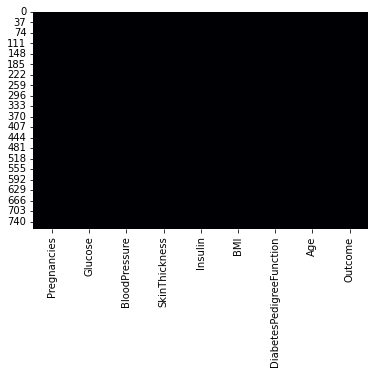

In [14]:
# Visualize missing variables
sns.heatmap(df.isnull(), cbar=False, cmap='magma')
plt.show()


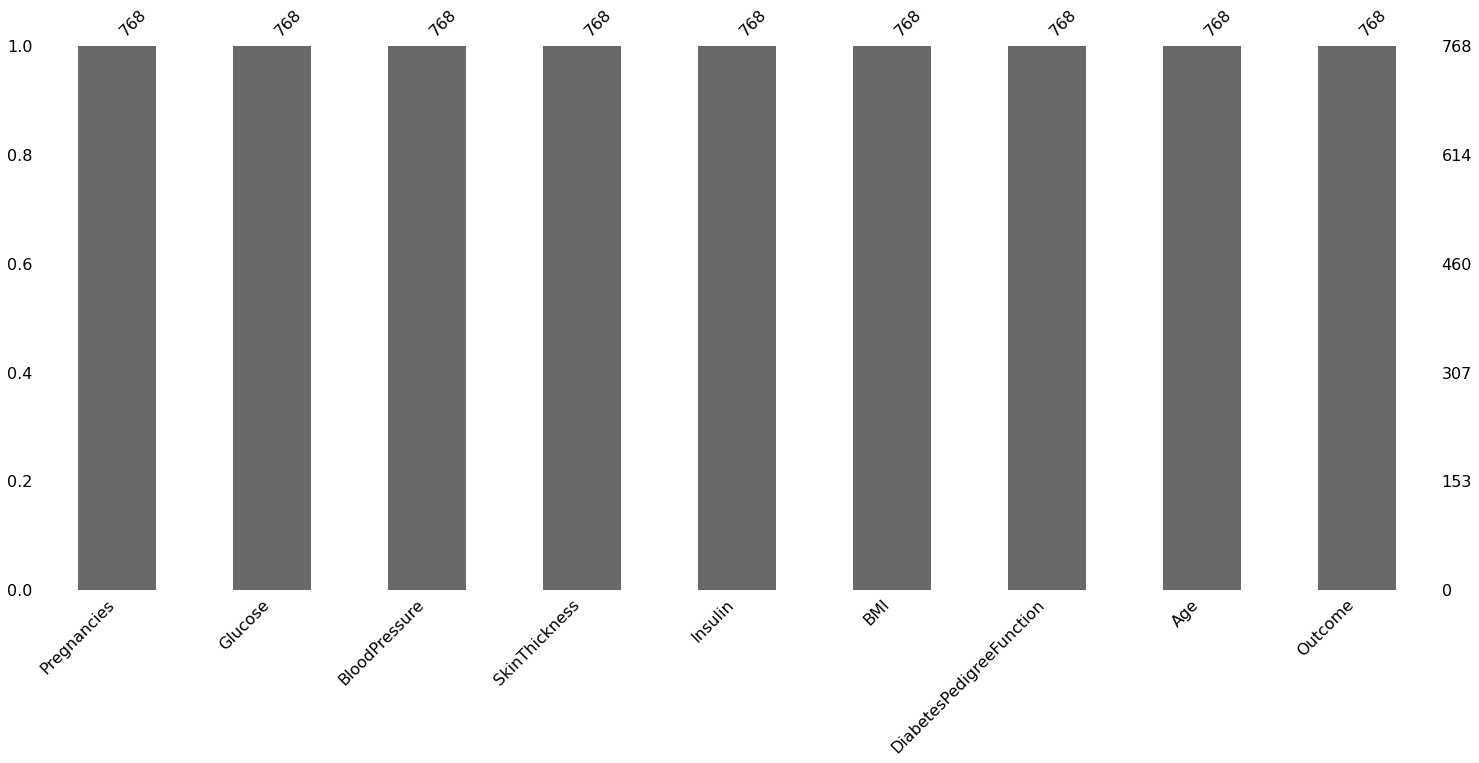

In [15]:
# Missing values overall view
msno.bar(df)
plt.show()


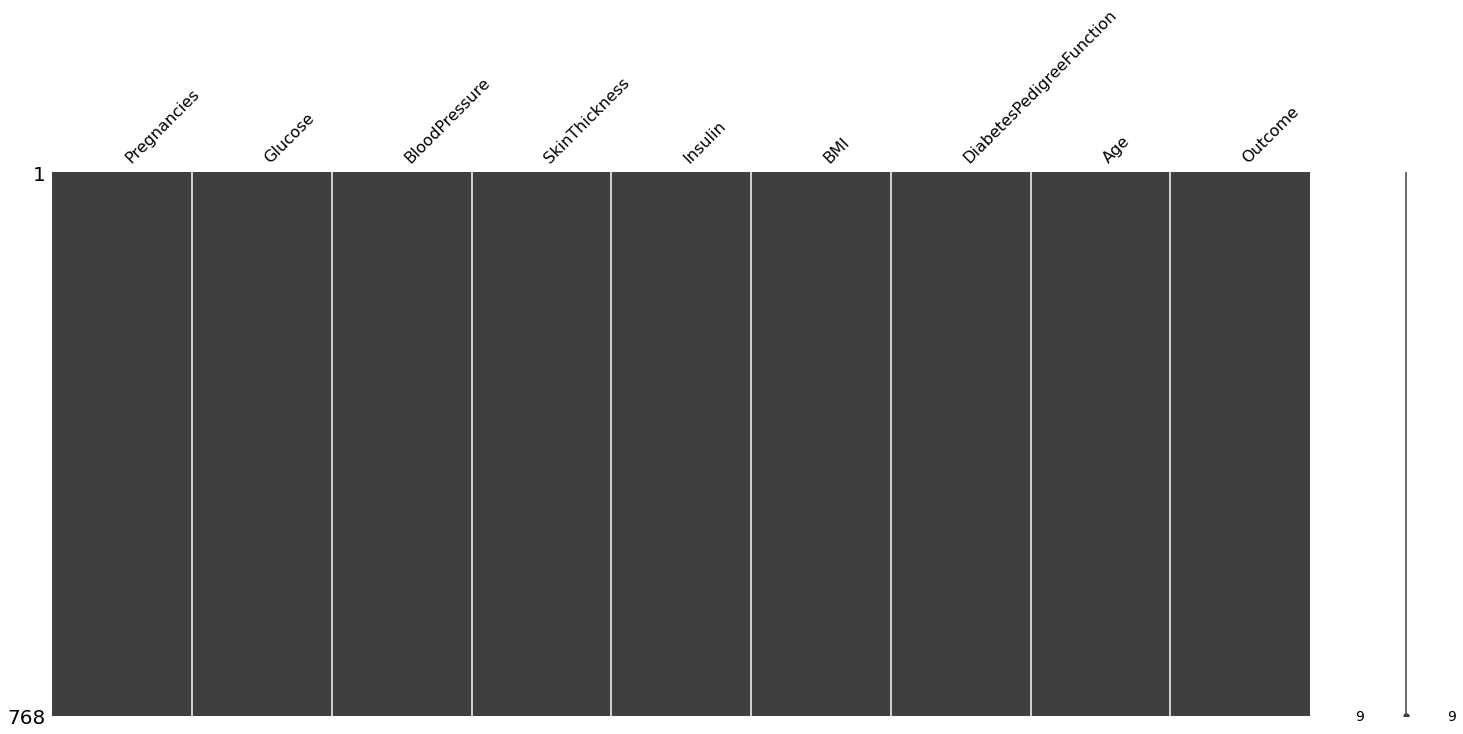

In [16]:
# Now, we can see the relationship between missing values
msno.matrix(df)
plt.show()


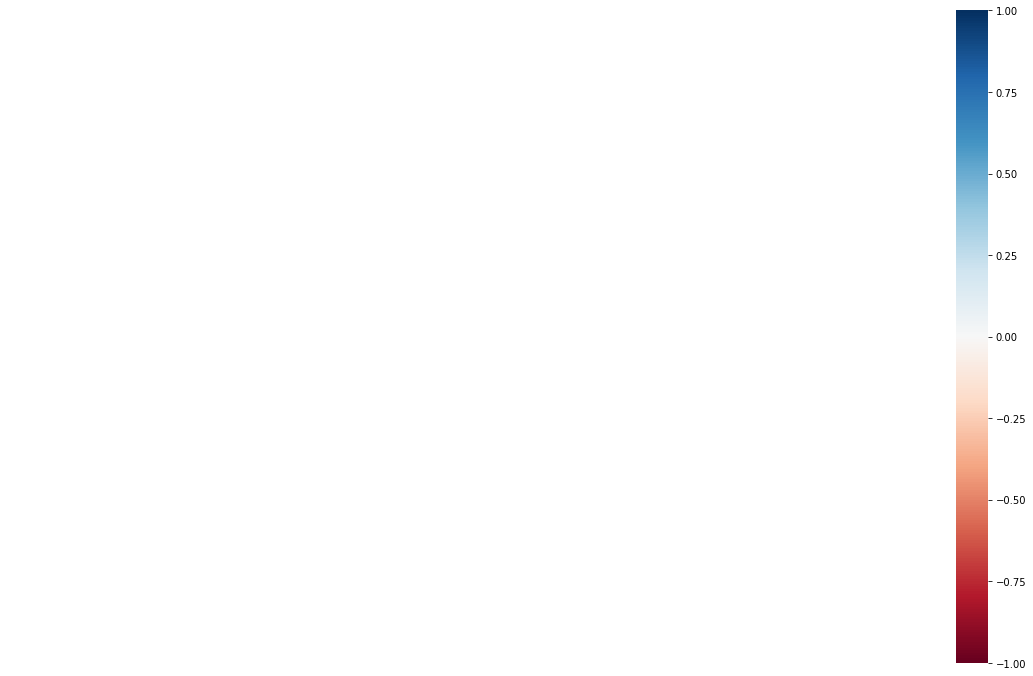

NameError: name 'variables_with_na' is not defined

In [17]:
# Nullity correlation visualization
msno.heatmap(df)
plt.show()

# Impute median values for missing values for numeral variables with respect to their class
# df = df.apply(lambda x: x.fillna(x.median()), axis=0)
for col in variables_with_na:
    df[col] = df[col].fillna(df.groupby("Outcome")[col].transform("median"))

# Check for missing values, again and control
df.isnull().sum()
df.isnull().sum().sum() # 0

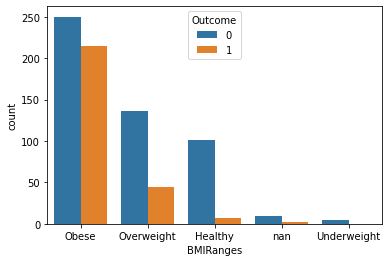

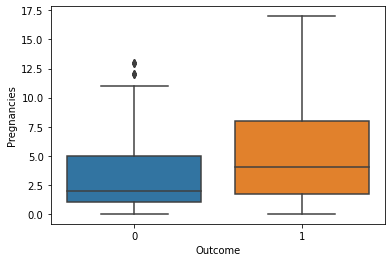

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
 9   BMIRanges                 768 non-null    object 
 10  AgeRanges                 768 non-null    object 
 11  GlucoseLevels             768 non-null    object 
dtypes: float64(3), int64(6), object(3)
memory usage: 72.1+ KB


In [ ]:
## FEATURE CREATION

# Create BMI ranges
df['BMIRanges'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=["Underweight", "Healthy", "Overweight", "Obese"])
df['BMIRanges'] = df['BMIRanges'].astype(str)
df.head()

# See the results for the new feature
df.groupby(["Outcome", "BMIRanges"]).describe()
df[['BMIRanges']].value_counts()
df.groupby(["BMIRanges"]).agg({"Outcome": [np.mean, np.count_nonzero, np.size]}) # Super!

# See the counts for each class that we created
sns.countplot(x='BMIRanges', hue='Outcome', data=df)
plt.show()

# Create Age ranges --> young, mid_aged, old
df['Age'].describe()
df['AgeRanges'] = pd.cut(x=df['Age'], bins=[15, 25, 65, 81], labels=["Young", "Mid_Aged", "Senior"])
df['AgeRanges'] = df['AgeRanges'].astype(str)
df.head()
# See the results for the new feature
df.groupby(["Outcome", "AgeRanges"]).describe()
df[['AgeRanges']].value_counts()
df.groupby(["AgeRanges"]).agg({"Outcome": [np.mean, np.count_nonzero, np.size]}) # Super!

# Create Insulin/Glucose ranges --> low, normla, secret, high
df['Glucose'].describe()
df['GlucoseLevels'] = pd.cut(x=df['Glucose'], bins=[0, 70, 99, 126, 200], labels=["Low", "Normal", "Secret", "High"])
df['GlucoseLevels'] = df['GlucoseLevels'].astype(str)
df.head()

# See the results for the new feature
df.groupby(["Outcome", "GlucoseLevels"]).describe()
df[['GlucoseLevels']].value_counts()
df.groupby(["GlucoseLevels"]).agg({"Outcome": [np.mean, np.count_nonzero, np.size]}) # Super!

# Create a feature that shows the ratio of pregnancies/age
#df['Pregnancies/Age'] = df['Pregnancies'] / df['Age']
#df['Pregnancies/Age'].describe()

# See the results for the new feature
sns.boxplot(x='Outcome', y='Pregnancies', data=df)
plt.show()

df.info()

In [ ]:
## LABEL AND ONE HOT ENCODING


# Catch numerical variables
cat_cols = [col for col in df.columns if df[col].dtypes == 'O']
len(cat_cols)


# Define a function to apply one hot encoding to categorical variables.
def one_hot_encoder(dataframe, categorical_cols, nan_as_category=True):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, dummy_na=False, drop_first=True)
    new_columns = [c for c in dataframe.columns if c not in original_columns]
    return dataframe, new_columns


df, new_cols_ohe = one_hot_encoder(df, cat_cols)
df.head()
len(new_cols_ohe)

df.info()

# Export the dataset for later use by modeling
df.to_csv(r'diabetes_prepared.csv', index=False)


# STANDARDIZATION

df.head()

# Catch numerical variables
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and col not in ["Outcome"]]
len(num_cols)

# MinMaxScaler

df_minmax_scaled = df.copy()

from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler()
df_minmax_scaled[num_cols] = transformer.fit_transform(df_minmax_scaled[num_cols])  # default value is between 0 and 1

df_minmax_scaled[num_cols].describe().T
len(num_cols)

# StandardScaler

df_std_scaled = df.copy()

from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
df_std_scaled[num_cols] = transformer.fit_transform(df_std_scaled[num_cols])

df_std_scaled[num_cols].describe().T
len(num_cols)

# RobustScaler

df_robust_scaled = df.copy()

from sklearn.preprocessing import RobustScaler
transformer = RobustScaler()
df_robust_scaled[num_cols] = transformer.fit_transform(df_robust_scaled[num_cols])

df_robust_scaled[num_cols].describe().T
len(num_cols)

# Check before modeling for missing values and outliers in the dataset
# df.isnull().sum().sum()
# has_outliers(df, num_cols)
df_minmax_scaled.isnull().sum().sum()
has_outliers(df_minmax_scaled, num_cols)

df_std_scaled.isnull().sum().sum()
has_outliers(df_std_scaled, num_cols)

df_robust_scaled.isnull().sum().sum()
has_outliers(df_robust_scaled, num_cols)

# Last look at the dataset
df.head()
df.info()

# Export the dataset for later use by modeling
#df.to_csv(r'C:\Users\yakup\PycharmProjects\dsmlbc\projects\diabetes_classification\diabetes_prepared.csv')
df_minmax_scaled.to_csv(r'diabetes_prepared_minmaxscaled.csv', index=False)
df_std_scaled.to_csv(r'diabetes_prepared_stdscaled.csv', index=False)
df_robust_scaled.to_csv(r'diabetes_prepared_robustscaled.csv', index=False)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
 9   BMIRanges_Obese           768 non-null    uint8  
 10  BMIRanges_Overweight      768 non-null    uint8  
 11  BMIRanges_Underweight     768 non-null    uint8  
 12  BMIRanges_nan             768 non-null    uint8  
 13  AgeRanges_Senior          768 non-null    uint8  
 14  AgeRanges_